<a href="https://colab.research.google.com/github/mozhganmirbagheri/DeepLearning/blob/main/DeepLearning_Anomaly_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, LayerNormalization, Dropout, Input, Embedding, Add,GlobalAveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [ ]:
# Load your dataset
data = pd.read_csv('/content/drive/MyDrive/creditcard.csv')

In [ ]:
# Preprocessing
X = data.drop(columns=['Class'])  # Features
y = data['Class']  # Labels (0: Non-fraudulent, 1: Fraudulent)

# Scale the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [ ]:
# Positional Encoding
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, sequence_length, d_model):
        super(PositionalEncoding, self).__init__()
        self.positional_encoding = self.positional_encoding(sequence_length, d_model)

    def positional_encoding(self, sequence_length, d_model):
        positions = np.arange(sequence_length)[:, np.newaxis]
        indices = np.arange(d_model)[np.newaxis, :]
        angle_rates = 1 / np.power(10000, (2 * (indices // 2)) / np.float32(d_model))
        angle_rads = positions * angle_rates

        angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
        angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

        pos_encoding = angle_rads[np.newaxis, ...]

        return tf.cast(pos_encoding, dtype=tf.float32)

    def call(self, inputs):
        return inputs + self.positional_encoding[:, :tf.shape(inputs)[1], :]

In [ ]:
# Transformer Block
class TransformerBlock(tf.keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training=None):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [ ]:
# Define the model
def create_model(input_shape):
    inputs = Input(shape=input_shape)
    x = Embedding(input_dim=1000, output_dim=64)(inputs)
    x = PositionalEncoding(sequence_length=input_shape[0], d_model=64)(x)
    x = TransformerBlock(embed_dim=64, num_heads=2, ff_dim=64)(x)
    x = GlobalAveragePooling1D()(x)
    x = Dense(32, activation='relu')(x)
    x = Dropout(0.3)(x)
    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
# Build the model
model = create_model(X_train.shape[1:])

In [ ]:

# Train the model
model.fit(X_train, y_train, epochs=10, batch_size=64, validation_split=0.2)



Epoch 1/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 146s 49ms/step - accuracy: 0.9967 - loss: 0.0132 - val_accuracy: 0.9992 - val_loss: 0.0044
Epoch 2/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 141s 49ms/step - accuracy: 0.9991 - loss: 0.0057 - val_accuracy: 0.9993 - val_loss: 0.0043
Epoch 3/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 139s 49ms/step - accuracy: 0.9991 - loss: 0.0054 - val_accuracy: 0.9991 - val_loss: 0.0043
Epoch 4/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 140s 48ms/step - accuracy: 0.9991 - loss: 0.0053 - val_accuracy: 0.9991 - val_loss: 0.0038
Epoch 5/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 141s 48ms/step - accuracy: 0.9993 - loss: 0.0043 - val_accuracy: 0.9992 - val_loss: 0.0038
Epoch 6/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 140s 47ms/step - accuracy: 0.9993 - loss: 0.0040 - val_accuracy: 0.9991 - val_loss: 0.0039
Epoch 7/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 149s 49ms/step - accuracy: 0.9994 - loss: 0.0035 - val_accuracy: 0.9993 - val_loss: 0.0036
Epoch 8/10
2849/2849 ━━━━━━━━━━━━━━━━━━━━ 141s 49ms/step - accuracy: 

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - accuracy: 0.9994 - loss: 0.0037
Test Accuracy: 99.94%


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

In [ ]:
y_true = y_test
y_pred = model.predict(X_test).ravel()

1781/1781 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step


In [ ]:
# Convert probabilities to binary predictions
y_pred_binary = (y_pred > 0.5).astype(int)

In [ ]:
# Calculate Precision, Recall, F1-Score
precision = precision_score(y_true, y_pred_binary)
recall = recall_score(y_true, y_pred_binary)
f1 = f1_score(y_true, y_pred_binary)

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1-Score: {f1:.2f}")


Precision: 0.87
Recall: 0.74
F1-Score: 0.80


In [ ]:
# Calculate ROC-AUC score
roc_auc = roc_auc_score(y_true, y_pred)

# Print ROC-AUC score
print(f"ROC-AUC: {roc_auc:.2f}")

ROC-AUC: 0.95


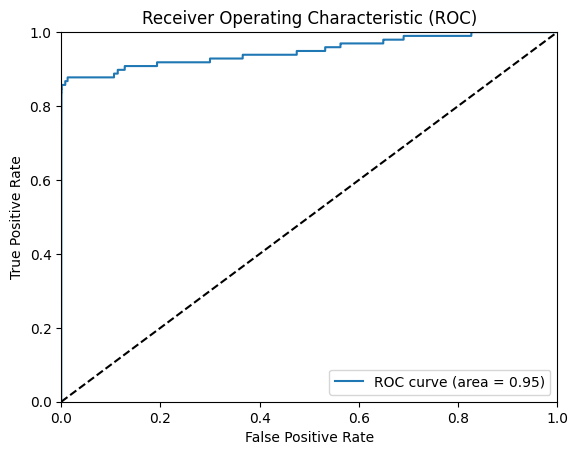

In [ ]:
# Plot ROC curve
fpr, tpr, _ = roc_curve(y_true, y_pred)
plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()